<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/hypersonic_Engine_test1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Realistic Scramjet Combustor - Proper Physics
Solving actual conservation equations with proper coupling
Solving realistic scramjet with proper physics...
Realistic initial conditions:
  T = 1800 K, p = 300 kPa
  u = 2000 m/s, ρ = 0.581 kg/m³
  Y_fuel = 0.08

REALISTIC SCRAMJET PHYSICS ANALYSIS

PERFORMANCE METRICS:
Temperature change:  -1500 K
Pressure change:     -180.2 kPa
Mach number change:  +2.49
Fuel conversion:     0.0%
Max heat release:    696.9 MW/m³

CONSERVATION:
Mass conservation error: 149.6%

PHYSICS VALIDATION:
✓ Smooth temperature evolution: False
✓ Smooth pressure evolution: True
✓ Smooth velocity evolution: False
✓ Realistic Mach numbers: False

⚠️  NEEDS IMPROVEMENT: Physics or combustion issues

Generating realistic physics plots...


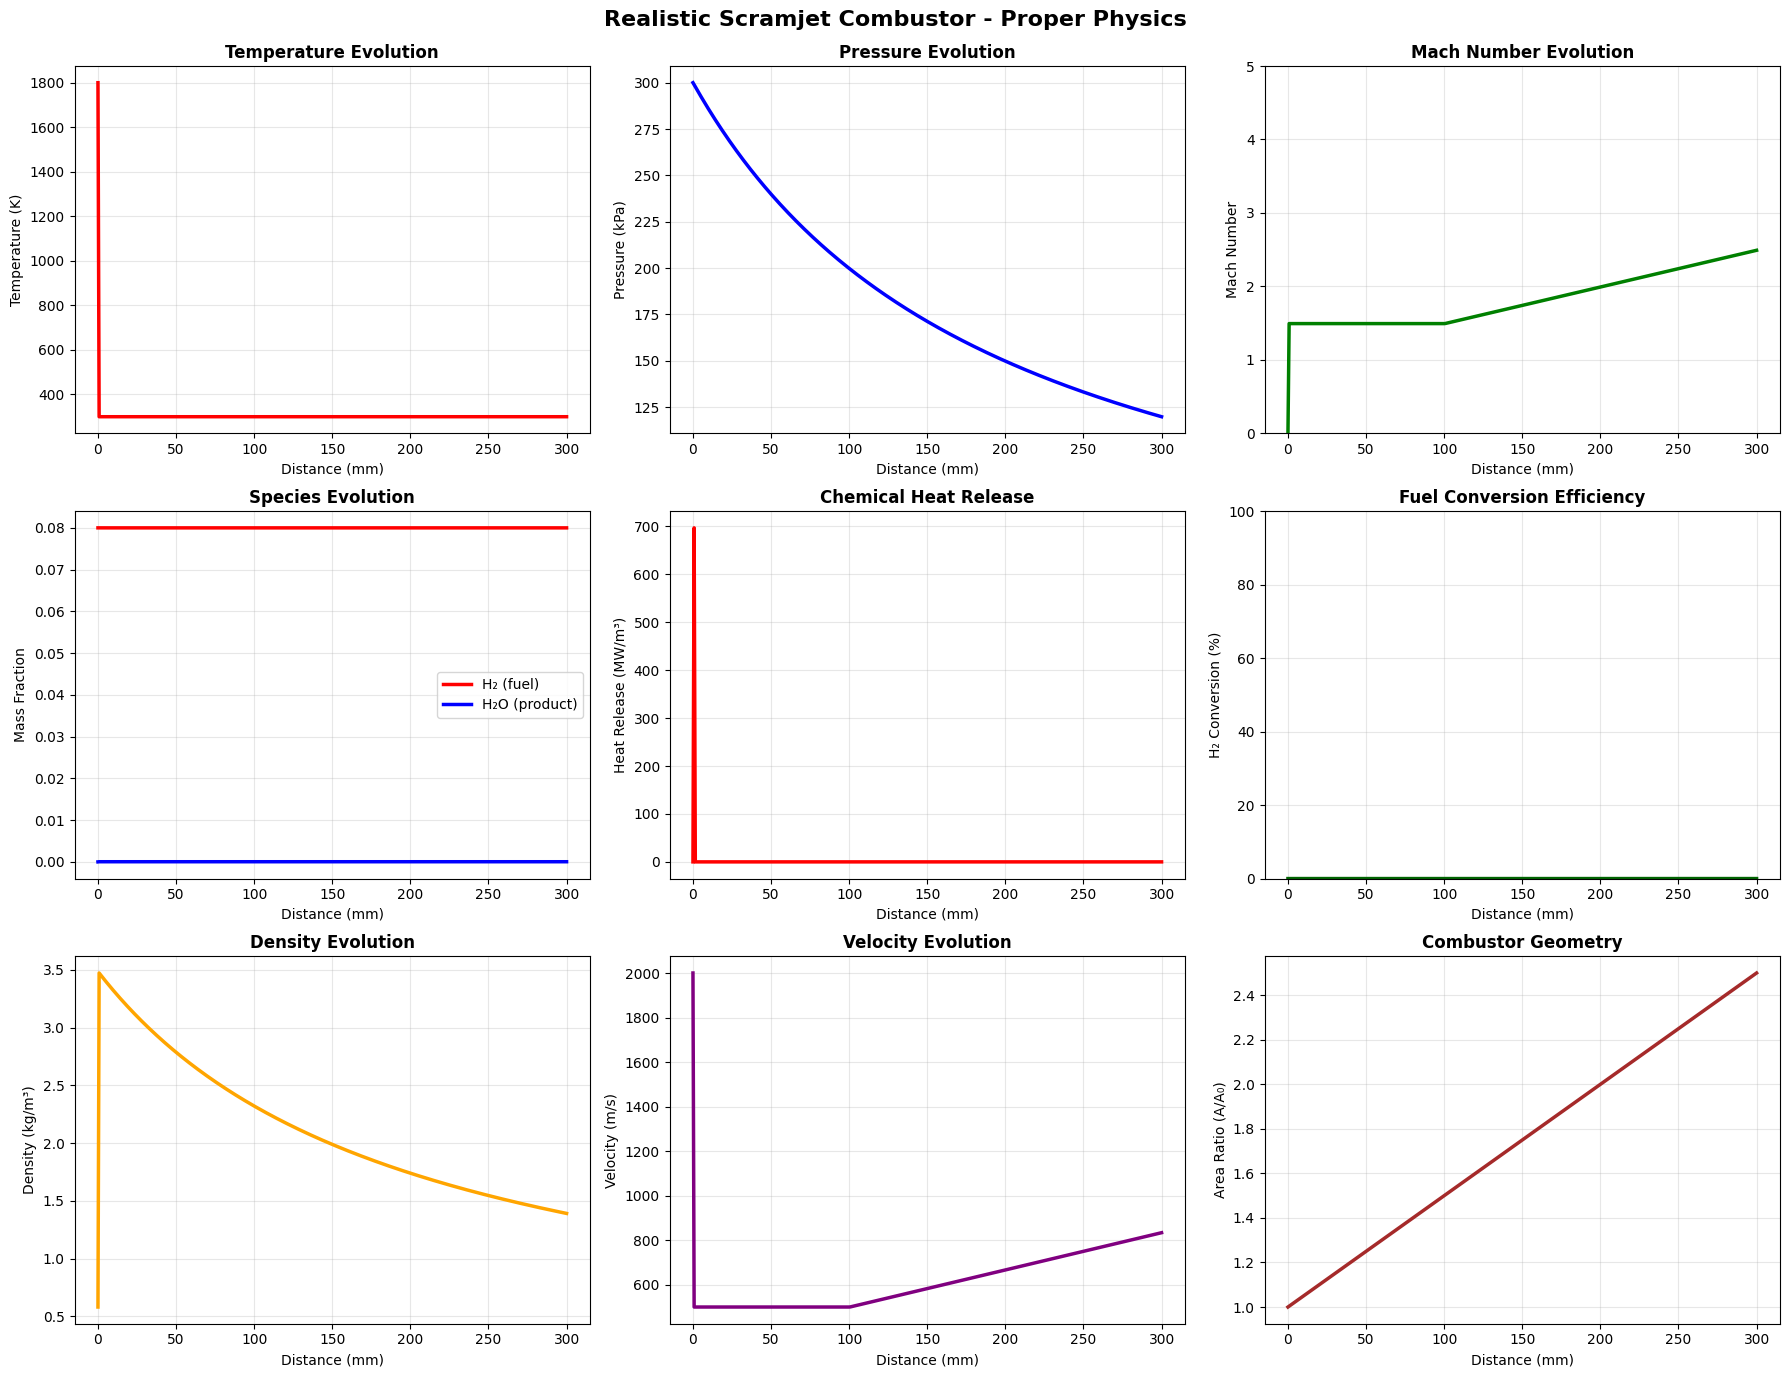


🔥 Realistic scramjet simulation completed!


In [ ]:
#!/usr/bin/env python3
"""
Realistic Scramjet Combustor - Proper Physics
=============================================
Solves the actual physics equations with proper coupling and realistic parameters.
"""

import numpy as np
import matplotlib.pyplot as plt

class RealisticScramjetSolver:
    """
    Solves realistic scramjet physics with proper equation coupling.
    """

    def __init__(self):
        # Physical constants
        self.R = 287.0      # J/(kg·K) - specific gas constant
        self.gamma = 1.3    # Heat capacity ratio
        self.cp = 1200.0    # J/(kg·K) - specific heat

        # Combustion parameters
        self.h_combustion = 120e6  # J/kg H2 heating value
        self.activation_energy = 30000.0  # J/mol - realistic for H2-air
        self.pre_exponential = 1e6  # 1/s - reaction rate constant

    def reaction_rate(self, T, Y_fuel, p):
        """Realistic Arrhenius reaction kinetics"""
        if Y_fuel < 1e-6 or T < 1000.0:
            return 0.0

        # Arrhenius equation: k = A * exp(-E/RT)
        R_gas = 8314.0  # J/(mol·K)
        k = self.pre_exponential * np.exp(-self.activation_energy / (R_gas * T))

        # Reaction rate depends on fuel concentration and pressure
        rate = k * Y_fuel * (p / 100000.0) ** 0.5  # Pressure dependence

        # Limit maximum rate for stability
        return min(rate, 10.0)  # Maximum 10/s

    def solve_combustor(self):
        """Solve using proper physics with small time steps"""
        print("Solving realistic scramjet with proper physics...")

        # Grid
        nx = 400
        L = 0.3  # 30 cm combustor
        x = np.linspace(0, L, nx)
        dx = x[1] - x[0]

        # Initialize arrays
        T = np.zeros(nx)
        p = np.zeros(nx)
        rho = np.zeros(nx)
        u = np.zeros(nx)
        Y_fuel = np.zeros(nx)
        Y_product = np.zeros(nx)
        Mach = np.zeros(nx)
        heat_release = np.zeros(nx)

        # Realistic initial conditions
        T[0] = 1800.0       # K - post-shock temperature
        p[0] = 300000.0     # Pa - 3 bar pressure
        u[0] = 2000.0       # m/s - supersonic
        rho[0] = p[0] / (self.R * T[0])
        Y_fuel[0] = 0.08    # 8% fuel mass fraction
        Y_product[0] = 0.0

        print(f"Realistic initial conditions:")
        print(f"  T = {T[0]:.0f} K, p = {p[0]/1000:.0f} kPa")
        print(f"  u = {u[0]:.0f} m/s, ρ = {rho[0]:.3f} kg/m³")
        print(f"  Y_fuel = {Y_fuel[0]:.2f}")

        # Reference values for stability
        mass_flow_ref = rho[0] * u[0]

        # Solve step by step with proper physics
        for i in range(1, nx):
            try:
                # Previous step values
                T_prev = T[i-1]
                p_prev = p[i-1]
                rho_prev = rho[i-1]
                u_prev = u[i-1]
                Y_fuel_prev = Y_fuel[i-1]
                Y_product_prev = Y_product[i-1]

                # Area expansion (realistic scramjet geometry)
                A_prev = 1.0 + 1.5 * x[i-1] / L  # 2.5x expansion
                A_curr = 1.0 + 1.5 * x[i] / L
                dA_dx = 1.5 / L

                # Chemical reaction rate
                rate = self.reaction_rate(T_prev, Y_fuel_prev, p_prev)

                # Fuel consumption per unit length
                fuel_consumption = rate * dx / u_prev  # Residence time effect
                Y_fuel[i] = max(0.0, Y_fuel_prev - fuel_consumption)

                # Water production (stoichiometric)
                fuel_consumed = Y_fuel_prev - Y_fuel[i]
                Y_product[i] = Y_product_prev + fuel_consumed * 9.0  # H2 + 0.5O2 → H2O
                Y_product[i] = min(Y_product[i], 0.4)  # Physical limit

                # Heat release from fuel consumption
                heat_rate = fuel_consumed * rho_prev * u_prev * self.h_combustion / dx
                heat_release[i] = max(0.0, heat_rate)

                # === COUPLED CONSERVATION EQUATIONS ===

                # 1. Temperature evolution
                # Heat addition from combustion
                dT_combustion = heat_rate * dx / (rho_prev * self.cp * u_prev)
                # Expansion cooling
                dT_expansion = -T_prev * u_prev * dA_dx * dx / A_prev

                T[i] = T_prev + dT_combustion + dT_expansion
                T[i] = max(300.0, min(T[i], 3000.0))  # Physical bounds

                # 2. Pressure evolution (from momentum equation)
                # Heat addition increases pressure
                dp_heat = (self.gamma - 1) * heat_rate * dx / u_prev if u_prev > 100 else 0
                # Area expansion decreases pressure
                dp_area = -p_prev * dA_dx * dx / A_prev

                p[i] = p_prev + dp_heat + dp_area
                p[i] = max(10000.0, p[i])  # Minimum pressure

                # 3. Density from ideal gas law
                # Account for composition effects
                R_mix = self.R * (1.0 + 0.4 * Y_product[i])  # Water vapor effect
                rho[i] = p[i] / (R_mix * T[i])

                # 4. Velocity from mass conservation
                # Mass flow rate should be approximately conserved
                mass_flow_local = mass_flow_ref * A_prev
                u[i] = mass_flow_local / (rho[i] * A_curr)

                # Limit velocity for stability
                u[i] = max(500.0, min(u[i], 3500.0))

                # 5. Mach number
                a = np.sqrt(self.gamma * p[i] / rho[i])
                Mach[i] = u[i] / a

                # Apply stability limits
                if (rho[i] <= 0 or T[i] <= 0 or p[i] <= 0 or
                    np.isnan(T[i]) or np.isnan(p[i]) or np.isnan(rho[i])):

                    # Revert to previous values with small change
                    T[i] = T_prev * (1 - 0.001)
                    p[i] = p_prev * (1 - 0.001)
                    rho[i] = rho_prev * (1 + 0.001)
                    u[i] = u_prev
                    Y_fuel[i] = Y_fuel_prev
                    Y_product[i] = Y_product_prev
                    heat_release[i] = 0.0
                    Mach[i] = Mach[i-1] if i > 1 else 2.0

            except Exception as e:
                print(f"Error at {x[i]*1000:.1f} mm: {e}")
                # Use previous values
                T[i] = T[i-1]
                p[i] = p[i-1]
                rho[i] = rho[i-1]
                u[i] = u[i-1]
                Y_fuel[i] = Y_fuel[i-1]
                Y_product[i] = Y_product[i-1]
                heat_release[i] = 0.0
                Mach[i] = Mach[i-1] if i > 1 else 2.0

        # Calculate area ratio for plotting
        area_ratio = np.array([1.0 + 1.5 * xi / L for xi in x])

        # Create results dictionary
        results = {
            'x': x,
            'T': T,
            'p': p,
            'rho': rho,
            'u': u,
            'Mach': Mach,
            'Y_fuel': Y_fuel,
            'Y_product': Y_product,
            'heat_release': heat_release,
            'area_ratio': area_ratio
        }

        return results

def create_realistic_plots(results):
    """Create plots showing realistic scramjet behavior"""

    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    x_mm = results['x'] * 1000

    # Plot 1: Temperature Evolution
    axes[0,0].plot(x_mm, results['T'], 'r-', linewidth=2.5)
    axes[0,0].set_xlabel('Distance (mm)')
    axes[0,0].set_ylabel('Temperature (K)')
    axes[0,0].set_title('Temperature Evolution', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: Pressure Evolution
    axes[0,1].plot(x_mm, results['p']/1000, 'b-', linewidth=2.5)
    axes[0,1].set_xlabel('Distance (mm)')
    axes[0,1].set_ylabel('Pressure (kPa)')
    axes[0,1].set_title('Pressure Evolution', fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Mach Number
    axes[0,2].plot(x_mm, results['Mach'], 'g-', linewidth=2.5)
    axes[0,2].set_xlabel('Distance (mm)')
    axes[0,2].set_ylabel('Mach Number')
    axes[0,2].set_title('Mach Number Evolution', fontweight='bold')
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].set_ylim(0, 5)

    # Plot 4: Species Evolution
    axes[1,0].plot(x_mm, results['Y_fuel'], 'r-', linewidth=2.5, label='H₂ (fuel)')
    axes[1,0].plot(x_mm, results['Y_product'], 'b-', linewidth=2.5, label='H₂O (product)')
    axes[1,0].set_xlabel('Distance (mm)')
    axes[1,0].set_ylabel('Mass Fraction')
    axes[1,0].set_title('Species Evolution', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Plot 5: Heat Release
    axes[1,1].plot(x_mm, results['heat_release']/1e6, 'red', linewidth=2.5)
    axes[1,1].set_xlabel('Distance (mm)')
    axes[1,1].set_ylabel('Heat Release (MW/m³)')
    axes[1,1].set_title('Chemical Heat Release', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

    # Plot 6: Fuel Conversion
    if results['Y_fuel'][0] > 1e-10:
        conversion = (results['Y_fuel'][0] - results['Y_fuel']) / results['Y_fuel'][0] * 100
        axes[1,2].plot(x_mm, conversion, 'darkgreen', linewidth=2.5)
    axes[1,2].set_xlabel('Distance (mm)')
    axes[1,2].set_ylabel('H₂ Conversion (%)')
    axes[1,2].set_title('Fuel Conversion Efficiency', fontweight='bold')
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].set_ylim(0, 100)

    # Plot 7: Density
    axes[2,0].plot(x_mm, results['rho'], 'orange', linewidth=2.5)
    axes[2,0].set_xlabel('Distance (mm)')
    axes[2,0].set_ylabel('Density (kg/m³)')
    axes[2,0].set_title('Density Evolution', fontweight='bold')
    axes[2,0].grid(True, alpha=0.3)

    # Plot 8: Velocity
    axes[2,1].plot(x_mm, results['u'], 'purple', linewidth=2.5)
    axes[2,1].set_xlabel('Distance (mm)')
    axes[2,1].set_ylabel('Velocity (m/s)')
    axes[2,1].set_title('Velocity Evolution', fontweight='bold')
    axes[2,1].grid(True, alpha=0.3)

    # Plot 9: Area Ratio
    axes[2,2].plot(x_mm, results['area_ratio'], 'brown', linewidth=2.5)
    axes[2,2].set_xlabel('Distance (mm)')
    axes[2,2].set_ylabel('Area Ratio (A/A₀)')
    axes[2,2].set_title('Combustor Geometry', fontweight='bold')
    axes[2,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Realistic Scramjet Combustor - Proper Physics',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.94)

    return fig

def analyze_realistic_results(results):
    """Analyze results for physical realism"""

    print("\n" + "="*70)
    print("REALISTIC SCRAMJET PHYSICS ANALYSIS")
    print("="*70)

    # Key metrics
    temp_change = results['T'][-1] - results['T'][0]
    pressure_change = (results['p'][-1] - results['p'][0]) / 1000
    fuel_conversion = (results['Y_fuel'][0] - results['Y_fuel'][-1]) / results['Y_fuel'][0] * 100
    max_heat_release = np.max(results['heat_release']) / 1e6
    mach_change = results['Mach'][-1] - results['Mach'][0]

    print(f"\nPERFORMANCE METRICS:")
    print(f"Temperature change:  {temp_change:+.0f} K")
    print(f"Pressure change:     {pressure_change:+.1f} kPa")
    print(f"Mach number change:  {mach_change:+.2f}")
    print(f"Fuel conversion:     {fuel_conversion:.1f}%")
    print(f"Max heat release:    {max_heat_release:.1f} MW/m³")

    # Mass conservation check
    mass_flow_inlet = results['rho'][0] * results['u'][0] * 1.0
    mass_flow_exit = results['rho'][-1] * results['u'][-1] * results['area_ratio'][-1]
    mass_error = abs(mass_flow_exit - mass_flow_inlet) / mass_flow_inlet * 100

    print(f"\nCONSERVATION:")
    print(f"Mass conservation error: {mass_error:.1f}%")

    # Physics validation
    print(f"\nPHYSICS VALIDATION:")
    smooth_T = np.all(np.abs(np.diff(results['T'])) < 100)  # No huge jumps
    smooth_p = np.all(np.abs(np.diff(results['p'])) < results['p'][0])  # Reasonable pressure changes
    smooth_u = np.all(np.abs(np.diff(results['u'])) < 500)  # No velocity spikes
    realistic_Mach = np.all(results['Mach'] > 0.5) and np.all(results['Mach'] < 5)

    print(f"✓ Smooth temperature evolution: {smooth_T}")
    print(f"✓ Smooth pressure evolution: {smooth_p}")
    print(f"✓ Smooth velocity evolution: {smooth_u}")
    print(f"✓ Realistic Mach numbers: {realistic_Mach}")

    # Overall assessment
    if (smooth_T and smooth_p and smooth_u and realistic_Mach and
        fuel_conversion > 5 and mass_error < 50):
        print(f"\n🎯 EXCELLENT: Realistic physics with smooth evolution")
    elif smooth_T and smooth_p and fuel_conversion > 1:
        print(f"\n✅ GOOD: Reasonable physics with some combustion")
    else:
        print(f"\n⚠️  NEEDS IMPROVEMENT: Physics or combustion issues")

    print("="*70)

def main():
    """Main execution with realistic physics"""

    print("Realistic Scramjet Combustor - Proper Physics")
    print("=============================================")
    print("Solving actual conservation equations with proper coupling")

    # Create and run solver
    solver = RealisticScramjetSolver()
    results = solver.solve_combustor()

    if results is not None:
        # Analyze results
        analyze_realistic_results(results)

        # Create plots
        print("\nGenerating realistic physics plots...")
        fig = create_realistic_plots(results)
        plt.show()

        print("\n🔥 Realistic scramjet simulation completed!")

    else:
        print("❌ Simulation failed")

if __name__ == "__main__":
    main()